# Proyek Klasifikasi Gambar: Butterfly Image Classification Project
- **Nama:** Widya Dwi Aryani
- **Email:** widyadwiaryani9@gmail.com
- **ID Dicoding:** M891D5X1958

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflow tensorflowjs

In [25]:
import os
import random
import shutil
import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import tensorflowjs as tfjs
import tensorflow as tf
from google.colab import files
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

## Data Preparation

### Data Loading

In [6]:
# SETUP KAGGLE TOKEN
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d gpiosenka/butterfly-images40-species
!unzip -q butterfly-images40-species.zip -d butterfly_dataset


Dataset URL: https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species
License(s): CC0-1.0
 96% 384M/399M [00:04<00:00, 78.1MB/s]
100% 399M/399M [00:04<00:00, 104MB/s] 


### Data Preprocessing

#### Split Dataset

In [7]:
# GABUNGKAN TRAIN, TEST, DAN VALID KE SATU FOLDER
seg_train = "butterfly_dataset/train"
seg_test = "butterfly_dataset/test"
seg_valid = "butterfly_dataset/valid"

merged_dir = "butterfly_merged"
os.makedirs(merged_dir, exist_ok=True)

for src_dir in [seg_train, seg_test, seg_valid]:
    for label in os.listdir(src_dir):
        label_dir = os.path.join(src_dir, label)
        if os.path.isdir(label_dir):
            target_dir = os.path.join(merged_dir, label)
            os.makedirs(target_dir, exist_ok=True)
            for img in os.listdir(label_dir):
                src_img = os.path.join(label_dir, img)
                if os.path.isfile(src_img):
                    shutil.copy(src_img, target_dir)

print("✅ Semua gambar berhasil digabung di folder:", merged_dir)


✅ Semua gambar berhasil digabung di folder: butterfly_merged


In [8]:
# SPLIT DATASET MENJADI TRAIN, VAL, TEST

def split_dataset(base_path, output_path, train_size=0.7, val_size=0.15, test_size=0.15):
    os.makedirs(output_path, exist_ok=True)

    for label in os.listdir(base_path):
        label_dir = os.path.join(base_path, label)
        if not os.path.isdir(label_dir):
            continue

        files = glob.glob(os.path.join(label_dir, "*"))
        if len(files) == 0:
            continue

        train_files, temp_files = train_test_split(files, train_size=train_size, random_state=42)
        val_files, test_files = train_test_split(temp_files, test_size=test_size / (val_size + test_size), random_state=42)

        for subset, subset_files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
            subset_dir = os.path.join(output_path, subset, label)
            os.makedirs(subset_dir, exist_ok=True)

            for f in subset_files:
                shutil.copy(f, subset_dir)

        print(f"{label}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")

split_dataset("butterfly_merged", "butterfly_split")

# HITUNG JUMLAH GAMBAR DI SETIAP SUBSET
def count_images_in_split(base_path):
    for subset in ["train", "val", "test"]:
        subset_dir = os.path.join(base_path, subset)
        total = 0
        print(f"\n{subset.upper()}:")
        for label in os.listdir(subset_dir):
            label_path = os.path.join(subset_dir, label)
            count = len(os.listdir(label_path)) if os.path.isdir(label_path) else 0
            total += count
            print(f"  {label:<20}: {count}")
        print(f"  Total images: {total}")

count_images_in_split("butterfly_split")

AMERICAN SNOOT: 77 train, 16 val, 17 test
PIPEVINE SWALLOW: 86 train, 19 val, 19 test
ADONIS: 91 train, 20 val, 20 test
GREY HAIRSTREAK: 89 train, 19 val, 20 test
CINNABAR MOTH: 95 train, 20 val, 21 test
MADAGASCAN SUNSET MOTH: 89 train, 19 val, 20 test
BROOKES BIRDWING: 118 train, 26 val, 26 test
DANAID EGGFLY: 98 train, 21 val, 21 test
EASTERN COMA: 95 train, 21 val, 21 test
ELBOWED PIERROT: 85 train, 18 val, 19 test
EMPEROR GUM MOTH: 98 train, 21 val, 22 test
PAPER KITE: 93 train, 20 val, 21 test
RED CRACKER: 99 train, 21 val, 22 test
MONARCH: 93 train, 20 val, 20 test
Iphiclus sister: 97 train, 21 val, 21 test
MESTRA: 87 train, 19 val, 19 test
GARDEN TIGER MOTH: 95 train, 20 val, 21 test
RED ADMIRAL: 85 train, 18 val, 19 test
CRECENT: 100 train, 21 val, 22 test
PEACOCK: 87 train, 19 val, 19 test
TWO BARRED FLASHER: 79 train, 17 val, 18 test
JULIA: 84 train, 18 val, 18 test
SILVER SPOT SKIPPER: 86 train, 19 val, 19 test
SLEEPY ORANGE: 109 train, 24 val, 24 test
BANDED TIGER MOTH: 98

## Modelling

In [17]:
# DATA AUGMENTATION
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

datagen_val_test = ImageDataGenerator(rescale=1./255)

# LOAD DATASET
train_gen = datagen_train.flow_from_directory(
    'butterfly_split/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

val_gen = datagen_val_test.flow_from_directory(
    'butterfly_split/val',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_gen = datagen_val_test.flow_from_directory(
    'butterfly_split/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_gen.class_indices)
print(f"Jumlah kelas: {num_classes}")

# BUILD MODEL CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(224,224,3)),
    BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),

    GlobalAveragePooling2D(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# COMPILE MODEL
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# CALLBACKS
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# TRAINING
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=40,
    callbacks=callbacks
)


Found 9117 images belonging to 100 classes.
Found 1961 images belonging to 100 classes.
Found 2016 images belonging to 100 classes.
Jumlah kelas: 100
Epoch 1/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 174s 535ms/step - accuracy: 0.0705 - loss: 4.2082 - val_accuracy: 0.0178 - val_loss: 5.6117 - learning_rate: 5.0000e-04
Epoch 2/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 132s 463ms/step - accuracy: 0.1909 - loss: 3.2611 - val_accuracy: 0.1622 - val_loss: 3.5724 - learning_rate: 5.0000e-04
Epoch 3/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 133s 466ms/step - accuracy: 0.2769 - loss: 2.7391 - val_accuracy: 0.3422 - val_loss: 2.5150 - learning_rate: 5.0000e-04
Epoch 4/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 134s 469ms/step - accuracy: 0.3730 - loss: 2.3770 - val_accuracy: 0.3325 - val_loss: 2.6080 - learning_rate: 5.0000e-04
Epoch 5/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 134s 469ms/step - accuracy: 0.4206 - loss: 2.1191 - val_accuracy: 0.4054 - val_loss: 2.2060 - learning_rate: 5.0000e-04
Epoch 6/40
285/285 ━━━━━━━━━━━━━━━━━━━━ 137s 479ms

## Evaluasi dan Visualisasi

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.8750 - loss: 0.4425

Test Accuracy: 88.49%
Test Loss: 0.4565

Rangkuman Peforma:
Train Accuracy     : 92.48%
Validation Accuracy: 87.81%
Test Accuracy      : 88.49%


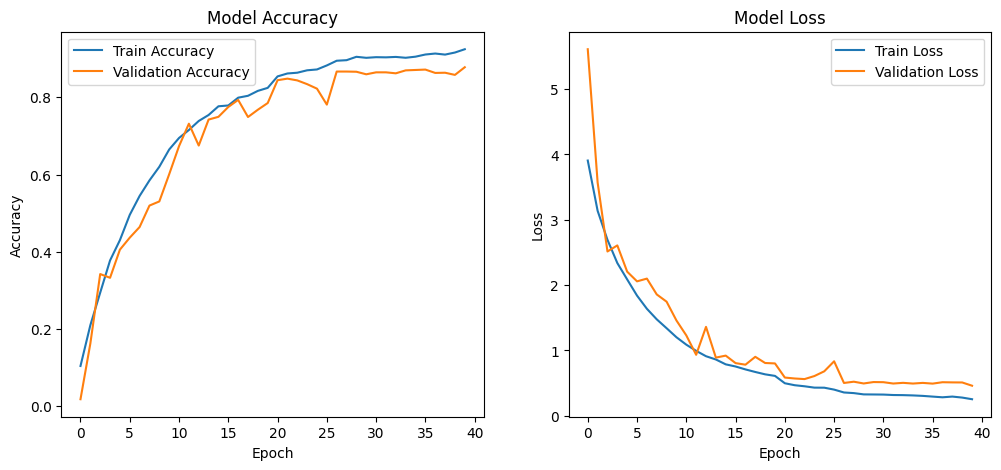

In [18]:
# EVALUASI MODEL DI TEST SET
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# RINGKASAN PERFORMA
print("\nRangkuman Peforma:")
print(f"Train Accuracy     : {max(history.history['accuracy'])*100:.2f}%")
print(f"Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
print(f"Test Accuracy      : {test_acc*100:.2f}%")

# VISUALISASI AKURASI DAN LOSS
plt.figure(figsize=(12, 5))

# Akurasi
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Konversi Model

In [21]:
# EXPORT MODEL
os.makedirs("submission/saved_model", exist_ok=True)
os.makedirs("submission/tflite", exist_ok=True)
os.makedirs("submission/tfjs_model", exist_ok=True)

# Simpan model untuk TFLite/TFServing
model.export("submission/saved_model")  # <-- gunakan export, bukan save

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("submission/saved_model")
tflite_model = converter.convert()

with open("submission/tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

# Simpan label
with open("submission/tflite/label.txt", "w") as f:
    for label in train_gen.class_indices.keys():
        f.write(label + "\n")

# Simpan untuk TensorFlow.js
tfjs.converters.save_keras_model(model, "submission/tfjs_model")

print("\nSemua format model berhasil disimpan ke folder 'submission/'!")

Saved artifact at 'submission/saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_28')
Output Type:
  TensorSpec(shape=(None, 100), dtype=tf.float32, name=None)
Captures:
  134130466070864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130466071824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130466066064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130466076816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130466063952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130466076048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130473414352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130473414160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130473414544: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134130473410128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134

failed to lookup keras version from the file,
    this is likely a weight only file

Semua format model berhasil disimpan ke folder 'submission/'!


Saving contoh.jpg to contoh.jpg
File uploaded: contoh.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Model memprediksi gambar ini sebagai: PEACOCK


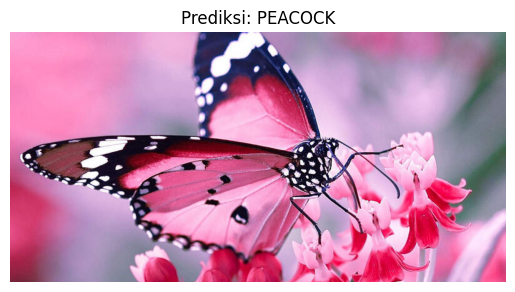

In [26]:
# Upload file
uploaded = files.upload()

# Ambil nama file yang diupload
img_path = list(uploaded.keys())[0]
print("File uploaded:", img_path)

# Load dan preprocessing gambar sesuai ukuran input model
img = image.load_img(img_path, target_size=(224, 224))  # 224x224 karena model dilatih pakai ini
img_array = image.img_to_array(img) / 255.0  # Normalisasi
img_array = np.expand_dims(img_array, axis=0)  # Tambahkan batch dimension

# Prediksi
pred = model.predict(img_array)
pred_class = np.argmax(pred, axis=1)[0]

# Ambil label kelas
labels = list(train_gen.class_indices.keys())
print(f"Model memprediksi gambar ini sebagai: {labels[pred_class]}")

# Tampilkan gambar dengan prediksi
plt.imshow(image.load_img(img_path))
plt.title(f"Prediksi: {labels[pred_class]}")
plt.axis('off')
plt.show()

## Inference (Optional)

In [27]:
requirements = """numpy==1.26.4
matplotlib==3.9.2
scikit-learn==1.5.1
tqdm==4.66.1
tensorflow==2.17.0
tensorflowjs==4.20.0
"""

# Buat folder submission jika belum ada
import os
os.makedirs("submission", exist_ok=True)

# Tulis file requirements.txt
with open("submission/requirements.txt", "w") as f:
    f.write(requirements)

print("✅ File requirements.txt berhasil dibuat di folder submission/")


✅ File requirements.txt berhasil dibuat di folder submission/


In [28]:
readme_content = """# Butterfly Image Classification Project 🦋

This project focuses on classifying **40 species of butterflies** using a Convolutional Neural Network (CNN) built with TensorFlow and Keras.

## Dataset
The dataset is sourced from Kaggle:
> [Butterfly Images - 40 Species](https://www.kaggle.com/datasets/gpiosenka/butterfly-images40-species)

After downloading, all images from the original train, test, and validation sets were merged and re-split into:
- **70%** training data
- **15%** validation data
- **15%** testing data

## Model Performance
- **Train Accuracy:** 92.48%
- **Validation Accuracy:** 87.81%
- **Test Accuracy:** 88.49%
- **Test Loss:** 0.4565

The model achieves strong accuracy across datasets, showing good generalization on unseen butterfly images.

## Model Architecture
The CNN model includes:
- Multiple **Conv2D** layers with ReLU activation and **BatchNormalization**
- **MaxPooling2D** for downsampling
- **GlobalAveragePooling2D** before the dense layers
- **Dropout (0.4)** for regularization
- **Softmax output layer** for 40-class classification

**Optimizer:** `Adam (lr=5e-4)`
**Loss Function:** `Categorical Crossentropy`

## Data Augmentation
To improve robustness and prevent overfitting, the training data was augmented using:
- Rotation (±25°)
- Width/height shift (±10%)
- Zoom (±20%)
- Shear transformation
- Horizontal flip
- Brightness adjustment (0.8–1.2)

## Example Prediction
Example uploaded image (`contoh.jpg`) was predicted as:
> **Class: PEACOCK**

The image was also displayed in Colab with the predicted label overlayed.

## Model Export
The trained model was exported to multiple formats for deployment:
- **TensorFlow SavedModel** → `submission/saved_model/`
- **TensorFlow Lite (.tflite)** → `submission/tflite/model.tflite`
- **TensorFlow.js** → `submission/tfjs_model/`

Each format allows easy integration across platforms (mobile, web, or backend).

## Summary
- The CNN successfully recognizes 40 butterfly species with ~88% accuracy.
- Augmentation and Batch Normalization improved model stability.
- The model is ready for deployment in both **mobile (TFLite)** and **web (TF.js)** environments.

---

**Built with:**
- Python 🐍
- TensorFlow + Keras 🤖
- Google Colab ☁️
- Kaggle Dataset 📊
"""

with open("submission/README.md", "w", encoding="utf-8") as f:
    f.write(readme_content)

print("✅ File README.md berhasil dibuat di folder submission/")


✅ File README.md berhasil dibuat di folder submission/


In [30]:
!zip -r submission.zip submission/

updating: submission/ (stored 0%)
updating: submission/README.md (deflated 46%)
updating: submission/tflite/ (stored 0%)
updating: submission/tflite/label.txt (deflated 49%)
updating: submission/tflite/model.tflite (deflated 8%)
updating: submission/tfjs_model/ (stored 0%)
updating: submission/tfjs_model/group1-shard1of1.bin (deflated 7%)
updating: submission/tfjs_model/model.json (deflated 91%)
updating: submission/requirements.txt (deflated 17%)
updating: submission/saved_model/ (stored 0%)
updating: submission/saved_model/assets/ (stored 0%)
updating: submission/saved_model/fingerprint.pb (stored 0%)
updating: submission/saved_model/variables/ (stored 0%)
updating: submission/saved_model/variables/variables.index (deflated 73%)
updating: submission/saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
updating: submission/saved_model/saved_model.pb (deflated 89%)


In [31]:
from google.colab import files
files.download("submission.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>